# Segmentation Workflow

The purpose of this jupyter notebook is to perform pre-processing, segmentation, and labeling of segmented ROIs from two-photon calcium imaging datasets

**Preprocessing** steps convert the image to grayscale and performs unsharp masking to remove variations in background fluorescence.

**Segmentation** takes place using watershed transform seeded by the local maximum of the distance transform of the binarized ROI image



First we need to import the important packages we will use and mount the notebook to drive. This notebook uses `skimage` for image processing and the `pyplot` module of `matplotlib` for image visualization



In [2]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import os

# mount drive- following tutorial at https://medium.com/ml-book/simplest-way-to-open-files-from-google-drive-in-google-colab-fae14810674
from google.colab import drive
drive.mount('/content/drive')
 

Mounted at /content/drive


First, we need to open the image with the neurons that we will be segmenting. This consists of two parts, the directory where the image is stored (`im_dir`) and the name of the image to open with its file extension (`fname`)

In [6]:

im_dir='drive/My Drive/CHEME 599/Project/images'; # image path to open
fname='PL01_day3.jpg' # the name of the file to open 


Next we need to load the image and convert it into grayscale. This pipeline has been tested on images with `.jpg`, .`png`, `.tif`, and`.tiff` formats. Refer to the `matplotlib` documentation to modify for import of other formats

If the image has been properly imported and converted to grayscale, a two element tuple should print and the correct image should be visible in the output from this cell.

(512, 512)


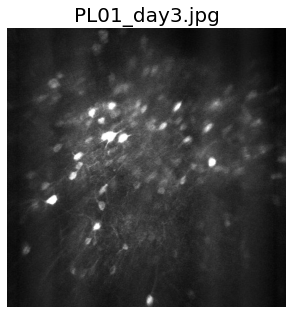

In [12]:
from skimage.util import img_as_ubyte, img_as_float
from skimage import color
im=plt.imread(os.path.join(im_dir, fname)); # read image 
im=color.rgb2gray(im)  # make the image grayscale
print(im.shape)
im=img_as_ubyte(img_as_float(im)) # this takes care of some weird import qwirks


fig, ax = plt.subplots(ncols=1, figsize=(5,6)) 
ax.imshow(im, cmap='gray')
ax.set_title(fname, fontsize=20)
ax.axis('off');


The major preprocessing step we will use is unsharp masking which is used to remove large fluctuations in background intensity across an image. This makes it much easier to differentiate neurons from general background fluorescence from neuropil. The cell below defines the function (`unsharp_mask`) we will use later in the notebook to perform the operation


In [15]:
def unsharp_mask(im, scale): 
  ''' Perform unsharp masking on an image

  Generates a sharper image `im_us` from input image `im`
  by removing slowly varying background noise. Background
  noise is calculated using a width of 1/`scale` of the 
  image width. Rescales the resulting image to take adavantage
  of a wider range of pixel fluorescence available. 
    

  Parameters
  ----------
  im : a grayscale image
      color images should be converted using rgb2gray
  scale : int
      an integer describing the width of the box used
      to blur the image. The box will be 1/`scale` times
      the image width wide

  Returns
  -------
  im_us
      an ubyte image that representes `im` unsharp masked
      using an image with mask width  `scale`
    
  Notes
  -----
    Uses mean filter to create the background image 

  Examples
  --------
  #denoise grayscale cameraman image
  from skimage import data
  im=data.camera() # load cameraman image
  im_us=unsharp_mask(im,2) # perform unsharp masking...
  #with mean filter with scale box 1/2 im width
  plt.imshow(im_us) # show the resulting image 

  #denoise color image 
  from skimage import data, color
  im=sk.data.chelsea()
  im=sk.color.rgb2gray(im) # important additonal tep
  im_us=unsharp_mask(im,40)
  plt.imshow(im_us)
  '''
  from skimage.morphology import square
  from skimage.filters import rank
  from skimage.util import img_as_ubyte

  im=img_as_ubyte(im) # ensure the image is in uint8 form
  length=int((np.round(im.shape[1]/scale,0))); # set filter size to 1/ scaling factor of image size 
  selem=square(length) # create mask that is half as wide as the image rounded up
  background=1.0*rank.mean(im, selem) # generate the background image
  im_us=im-background # subtract background from main image
  # normalize the image fluoresence
  im_min=np.min(im_us)
  im_range = np.max(im_us)-im_min
  im_us = np.round(255*(im_us - im_min)/im_range, 0) # normalize
  return(im_us)

It is time to perform unsharp masking on the image. The `unsharp_mask` function takes two inputs:
- `im`: the image to process
- `scale`: the width of the mask used to generate the background image, expressed as a ratio of the image width. For example, an input of 10 would use a mask of the image width divided by 10

This cell outpus the original and unsharp masked images. Notice how much more uniform the background of the unsharp masked image is compared to the original.

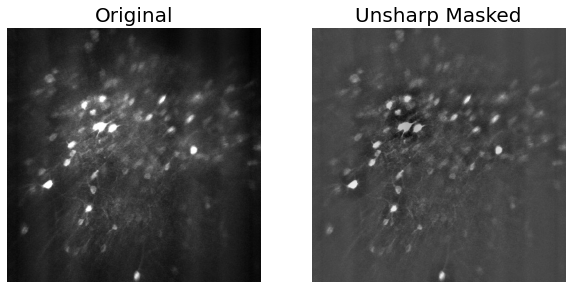

In [17]:
im_us=unsharp_mask(im,10)

fig, ax = plt.subplots(ncols=2, figsize=(10,6)) 
titles=('Original', 'Unsharp Masked')
for axi, title in zip(ax,titles):
  axi.axis('off')
  axi.set_title(title, fontsize=20)

ax[0].imshow(im, cmap='gray')
ax[1].imshow(im_us, cmap='gray');

Now it is time to segment the neurons!
We need to import some functions to do this

In [ ]:
from skimage.morphology import binary_opening
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage
from scipy.ndimage import label
from skimage.color import label2rgb

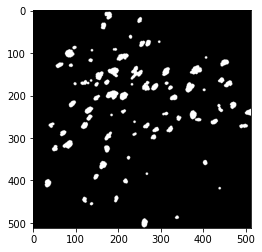

In [ ]:
im5=img_as_float(im_us>80)

im3=binary_opening(im5, disk(3))

plt.imshow(im3, cmap='gray')

(-0.5, 511.5, 511.5, -0.5)

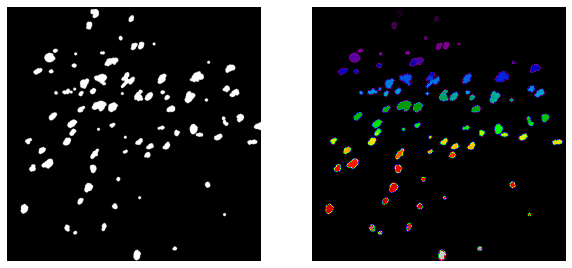

In [ ]:


distance = ndimage.distance_transform_edt(im3)#
localMax = peak_local_max(distance, indices=False, min_distance=8)
markers = ndimage.label(localMax)[0]
labels = watershed(-distance, markers, mask=im3)


fig, axes=plt.subplots(ncols=2, figsize=(10,6))
axes[0].imshow(im3, cmap='gray')
axes[1].imshow(labels,cmap='nipy_spectral') 
axes[0].axis('off')
axes[1].axis('off')

(-0.5, 511.5, 511.5, -0.5)

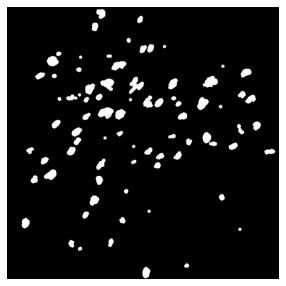

In [ ]:
from skimage.morphology import binary_opening
labels=labels>0;
im4=binary_opening(labels, disk(3))
fig, axes=plt.subplots(ncols=1, figsize=(5,5))
axes.imshow(im4, cmap='gray')
axes.axis('off')

(-0.5, 511.5, 511.5, -0.5)

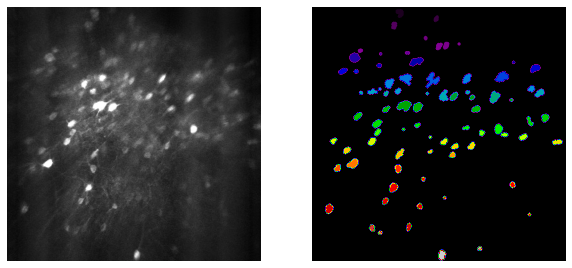

In [ ]:


labeled2, _ = label(im4)

fig, axes=plt.subplots(ncols=2, figsize=(10,6))
axes[0].imshow(im, cmap='gray')
axes[1].imshow(labeled2,cmap='nipy_spectral') 
axes[0].axis('off')
axes[1].axis('off')
